In [29]:
#Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sympy import *

#Interactive graph modules
# %matplotlib notebook
from ipywidgets import *
from matplotlib.colors import LogNorm

In [30]:
#Configure simulation paratmers
#Geometric Parameters
g = 1.62 # gravitational constant


In [31]:
#Set exhast gas parameters (fuel mixture estimate)
R = 8.314/0.028 #[J/mol·K] universal gas constant, normalized by molar mass
gamma = 1.4 # heat capacity ratio
mu_c = 17.49E-6 #[Pa.s] #viscosity in the rocket chamber

In [32]:
#Configure the surface geology parameters
D = (109) *1e-6 #diameter of dust particles (microns)
c = 0.6 #packing concentration in dust layer
sigma = 2500 #[kg/m3]density of dust particle

A_coh = 0 #cohesional shear stress (experimental)
tau_coh = 0 #cohesional shear stress (experimental)
alpha = (20)*np.pi/180 #static angle of repose of cohensionless particles (deg)
alpha_collapse = (25)*np.pi/180 #angle of repose at which avalanche start (deg)

K = 1 # shear stress augmentation factor

In [33]:
#Set rocket engine parameters
r_e = 0.005 #[m] nozzle radius exit
M_e = 5 #nozzle exit mach number
p_c = (1.25E6) #[Pa] rocket chamber pressure (max pressure)
T_c = 300 #[K] #temperature in the rocket chamber

In [34]:
def moving_average(array_var, n_pt=3):
    ret = np.cumsum(array_var, dtype=float)
    ret[n_pt:] = ret[n_pt:] - ret[:-n_pt]
    return ret[n_pt - 1:] / n_pt

In [35]:
def Area(y_arr,dr):
    area = 0
    for i in y_arr:
        area += i*dr
    return area

In [36]:
def simulate(r_arr, h_arr,t,dr,y,tau,dy_dt,update_freq):    
    #Loop through simulation time
    for i in range(1, len(t)):
        r = r_arr[i-1]
        h = h_arr[i-1]
        theta = np.arctan(r/h)
        beta = np.arctan(np.diff(np.transpose(y[:,i-1]))/dr)
        beta = np.insert(beta, 0, 0)    
        #Calculate derived values
        k = gamma*(gamma-1)*M_e**2 #hypersonic simularity parameter
        p_r = p_c*(1+gamma*M_e**2)/(1+(gamma-1)/2*M_e**2)**(gamma/(gamma-1)) #post-shock recovery pressure without inverse-square propagation
        p_s = np.minimum(p_r,(k+2)/2*(r_e/h)**2*p_r) #post-shock centerline pressure with inverse-square propagation
        p = p_s*np.cos(theta)**(k+4)*np.cos(beta)**2*(1-np.tan(theta)*np.tan(beta))**2 #ground pressure
        u = np.sqrt(2*gamma/(gamma-1)*R*T_c*(1-(p/p_s)**((gamma-1)/gamma))) #velocity parallel to surface
        q = (gamma/(gamma-1))*(1-(p/p_s)**((gamma-1)/gamma))*(p/p_s)**(1/gamma)*p_s #dynamic pressure
        rho = 2*q/(np.square(u)) #density
        mu = mu_c*(p/p_s)**((gamma-1)/(2*gamma)) #gas viscosity

        #Reynolds Numbers
        Re_D = rho*u*D/mu #particle Reynold number
        Re_theta = rho*u*r/mu #surface Reynold number

        #Fluid Coefficents
        C_d = 24/Re_D #+ 3/Re_D**2 +0.34 #friction coefficient of particles
        C_f = 0.84 #friction coefficient of surface

        #Calculated derived values continued
        tau[:,i] = K*C_f*q #surface shear
        tau_star = sigma*c*D*g*(np.cos(beta)*np.tan(alpha) - np.sin(beta)) + A_coh*D**(-3) + tau_coh #shear retaining stress
        Xi = 18*mu_c*h/(sigma*D**2*np.sqrt(R*T_c*(k+4)))*(1+((k+2)*D*C_d*p_r)/(72*np.sqrt(2)*mu_c*np.sqrt(R*T_c))*(r_e/h)**2) #goes inside the momentum factor
        a = 1/(0.5 + np.sqrt( 0.25 + (1/Xi) )) #momentum factor

        #Calculate erosion rate
        dy_dt[:,i] = 2*(tau[:,i]-tau_star)/(a*u*sigma*c*np.cos(beta)) # erosion rate
        dy_dt[:,i] = np.nan_to_num(dy_dt[:,i])

        #Apply errosion
        y[:,i] = y[:,i-1]-dy_dt[:,i]*(t[i]-t[i-1]) #surface modification due to erosion, forward euler scheme
        y[0,i] = y[1,i] #correcting for zero erosion at centerline.

        if True:
            y_minslope = y[:,i]
            beta_minslope = np.arctan(np.diff(np.transpose(y_minslope))/dr)
            beta_minslope = np.insert(beta, 0, 0)
            while max(abs(beta_minslope)) > alpha_collapse:
                for k in range(len(y_minslope)-1):
                    local_slope = np.arctan((y_minslope[k+1]-y_minslope[k])/dr)
                    if abs(local_slope)>alpha_collapse:
                        mid_point = (y_minslope[k+1] + y_minslope[k])/2
                        y_minslope[k] = mid_point - np.sign(local_slope)*alpha*(0.5*dr)
                        y_minslope[k+1] = mid_point + np.sign(local_slope)*alpha*(0.5*dr)
                beta_minslope = np.arctan(np.diff(np.transpose(y_minslope))/dr)
                beta_minslope = np.insert(beta_minslope, 0, 0)
            y[:,i] = y_minslope
        else:
            #Simple 3-point filtering
            y_filt = moving_average(np.concatenate((np.flip(y[:,i]), y[:,i])))
            y[:,i] = np.flip(y_filt[0:n])

        #Print time update
        if (i%update_freq ==0):
            print(str(i)+' of '+str(len(t)))
    
    #Return the erosion history
    return y

In [37]:
divert_v = 1 * (r_e*2) # 1 x/D per sec divert velocity (m)
descent_v = 10 * (r_e*2) # 10 h/D per sec descent velocity (m)
divert_dist_arr = np.linspace(0,1000,21) * (r_e*2) # an array of divert distances converted to (m)
divert_h_arr = np.linspace(90,10,17) * (r_e*2) # an array of divert heights converted to (m)

In [38]:
# import numpy as np
# np.linspace(0,100,11)
np.linspace(0,1000,21)
# np.linspace(90,10,17)

array([   0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,
        450.,  500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,
        900.,  950., 1000.])

In [39]:
# surface discretization parameters
dr = 0.005 # distance between each discretised point (m)
r_min = -100 * (r_e*2) # lower distance of simulation of 100 h/D (m) 

x_dim = len(divert_dist_arr)
y_dim = len(divert_h_arr)
area_results = np.zeros((x_dim,y_dim))

for ishaan,divert_dist in enumerate(divert_dist_arr):
    for bansal,divert_h in enumerate(divert_h_arr):
        print("At divert distance: ",divert_dist)
        descent_start = 100 * (2*r_e) # start at 100 h/D (m)
        #Initialize arrays for data storage

        # surface discretization parameters
        r_max = 100 * (r_e*2) + divert_dist # upper distance of simulation of 100 h/D + divert (m)
        n = int(abs(r_max-r_min)/dr) #surface discretisation
        r = np.linspace(r_min, r_max, n) # simulation x-axis

        #Time parameters
        t_max = descent_start/descent_v + divert_dist/divert_v
        dt = 0.001
        t_count = int(t_max/dt)
        update_freq = t_count/10
        t = np.linspace(0, t_max, t_count) #time vector

        stage1_end = descent_start/descent_v * (descent_start - divert_h)/descent_start
        stage2_duration = divert_dist/divert_v
        stage2_end = stage1_end + stage2_duration
        stage3_end = t_max
        del_x = divert_dist / (stage2_duration/dt) # lateral movement per timestep during divert 

        r_arr = []
        del_h = descent_start / int((t_max-stage2_duration)/dt) 
        h_arr = []
        for i in t:
            if i <= stage1_end or i > stage2_end:
                descent_start = descent_start - del_h 
                h_arr.append(descent_start)
                r_arr.append(r)
            else:
                h_arr.append(descent_start)
                r = r - del_x*np.ones(n)
                r_arr.append(r)

        y = np.zeros(shape=(n, len(t))) #surface elevation vector
        dy_dt = np.zeros(shape=(n, len(t))) #mass flow rate vector
        tau = np.zeros(shape=(n, len(t))) #surface shear
        y_sim = simulate(r_arr,h_arr,t,dr,y,tau,dy_dt,update_freq)
        area = Area(y_sim[:,-1],dr)
        area_results[ishaan,bansal] = area

In [40]:
np.savetxt("area_results.csv", abs(area_results.T), delimiter=",")

In [41]:
area_results_fromcsv = np.loadtxt("area_results.csv",delimiter=",")

In [42]:
area_results_mag = abs(area_results_fromcsv)

In [43]:
divert_dist_arr_hd = divert_dist_arr/(r_e*2)
divert_h_arr_hd = divert_h_arr/(r_e*2)

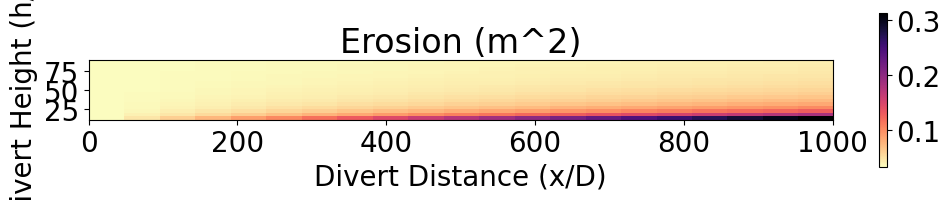

In [44]:
plt.figure(figsize=(12,2))
plt.imshow(area_results_mag, cmap='magma_r', interpolation='none', extent=[divert_dist_arr_hd[0],divert_dist_arr_hd[-1],divert_h_arr_hd[-1],divert_h_arr_hd[0]], aspect=14)
plt.xlabel("Divert Distance (x/D)")
plt.ylabel("Divert Height (h/D)")
plt.title("Erosion (m^2)")
plt.colorbar()

In [45]:
base_area = area_results_mag[0,0] # 0 x/D divert 
base_area

0.03224361911035124

In [48]:
# from matplotlib.animation import FuncAnimation
import matplotlib as mpl
import matplotlib.animation as ani
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# mpl.rcParams['animation.ffmpeg_path'] = r"C:\Users\ishaa\Downloads\ffmpeg-master-latest-win64-gpl-shared\ffmpeg-master-latest-win64-gpl-shared\bin\ffmpeg.exe"

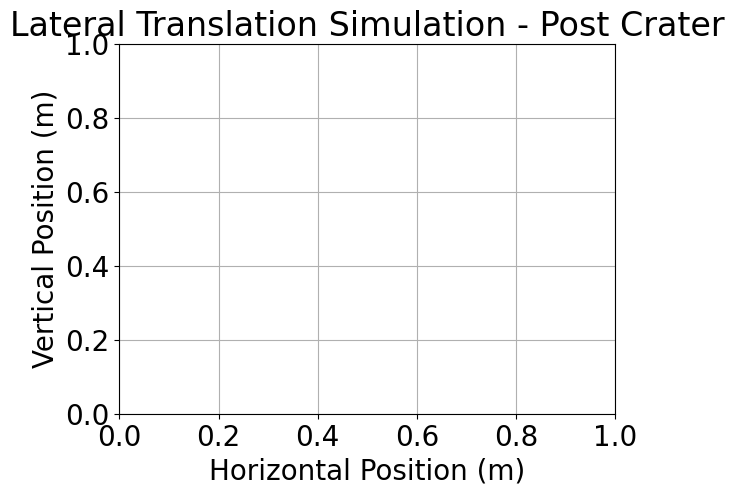

In [51]:
plt.figure()
plt.xlabel("Horizontal Position (m)")
plt.ylabel("Vertical Position (m)")
plt.title("Lateral Translation Simulation - Post Crater")
plt.grid()
plt.plot(r_arr[-1], y_sim[:,-1],"k")

In [52]:
# comparison
base_area_mag = abs(base_area)
del_area_results_perc = (area_results_mag - base_area_mag) / base_area_mag * 100

In [53]:
del_area_results_perc[0,0] = 0

In [89]:
plt.rcParams.update({'font.size': 30, 'font.family' : 'Times New Roman'})

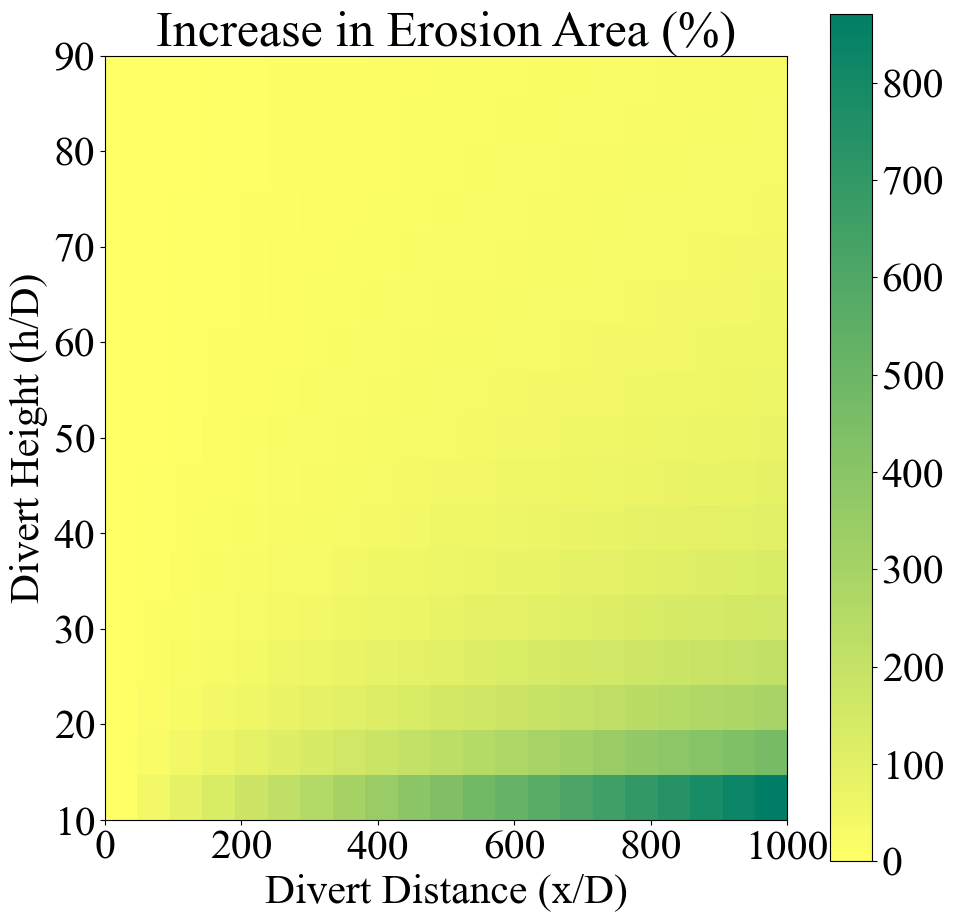

In [90]:
plt.figure(figsize=(11,11))
plt.imshow(del_area_results_perc, cmap='summer_r', interpolation='none', extent=[divert_dist_arr_hd[0],divert_dist_arr_hd[-1],divert_h_arr_hd[-1],divert_h_arr_hd[0]],aspect=14)
plt.xlabel("Divert Distance (x/D)")
plt.ylabel("Divert Height (h/D)")
plt.title("Increase in Erosion Area (%)")
plt.colorbar()

In [91]:
dist_num = del_area_results_perc.shape[1]
height_num = del_area_results_perc.shape[0]


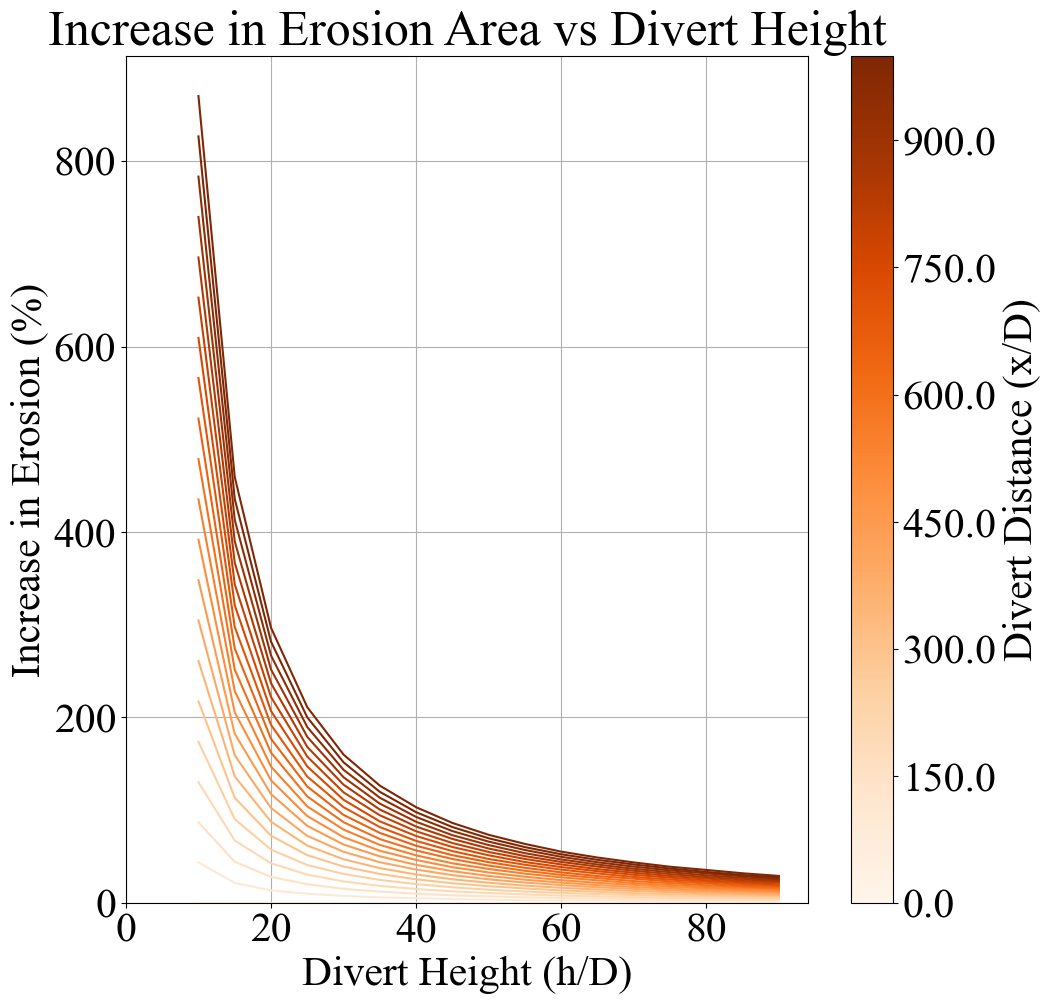

In [92]:
fig, ax = plt.subplots(figsize=(11,11))

grey_colors = plt.cm.gray(divert_dist_arr_hd)

for dist_idx in range(dist_num):
    dist_label = divert_dist_arr_hd[dist_idx]
    # colour = grey_colors[dist_idx]
    colour = plt.cm.Oranges(dist_idx / (dist_num - 1) + 0.05)
    ax.plot(divert_h_arr_hd, del_area_results_perc[:,dist_idx], label=dist_label, color=colour)


# Add colorbar
norm = Normalize(vmin=min(divert_dist_arr_hd), vmax=max(divert_dist_arr_hd))
sm = ScalarMappable(cmap=plt.cm.Oranges, norm=norm)
sm.set_array([])

# Specify the Axes for the colorbar
cbar = plt.colorbar(sm, ax=ax, label="Divert Distance (x/D)")
cbar.set_ticks(divert_dist_arr_hd[::3])
cbar.set_ticklabels(divert_dist_arr_hd[::3])

plt.title("Increase in Erosion Area vs Divert Height")
plt.xlabel("Divert Height (h/D)")
plt.ylabel("Increase in Erosion (%)")
plt.ylim(-0.1)
plt.xlim(0)
plt.grid() 
plt.show()

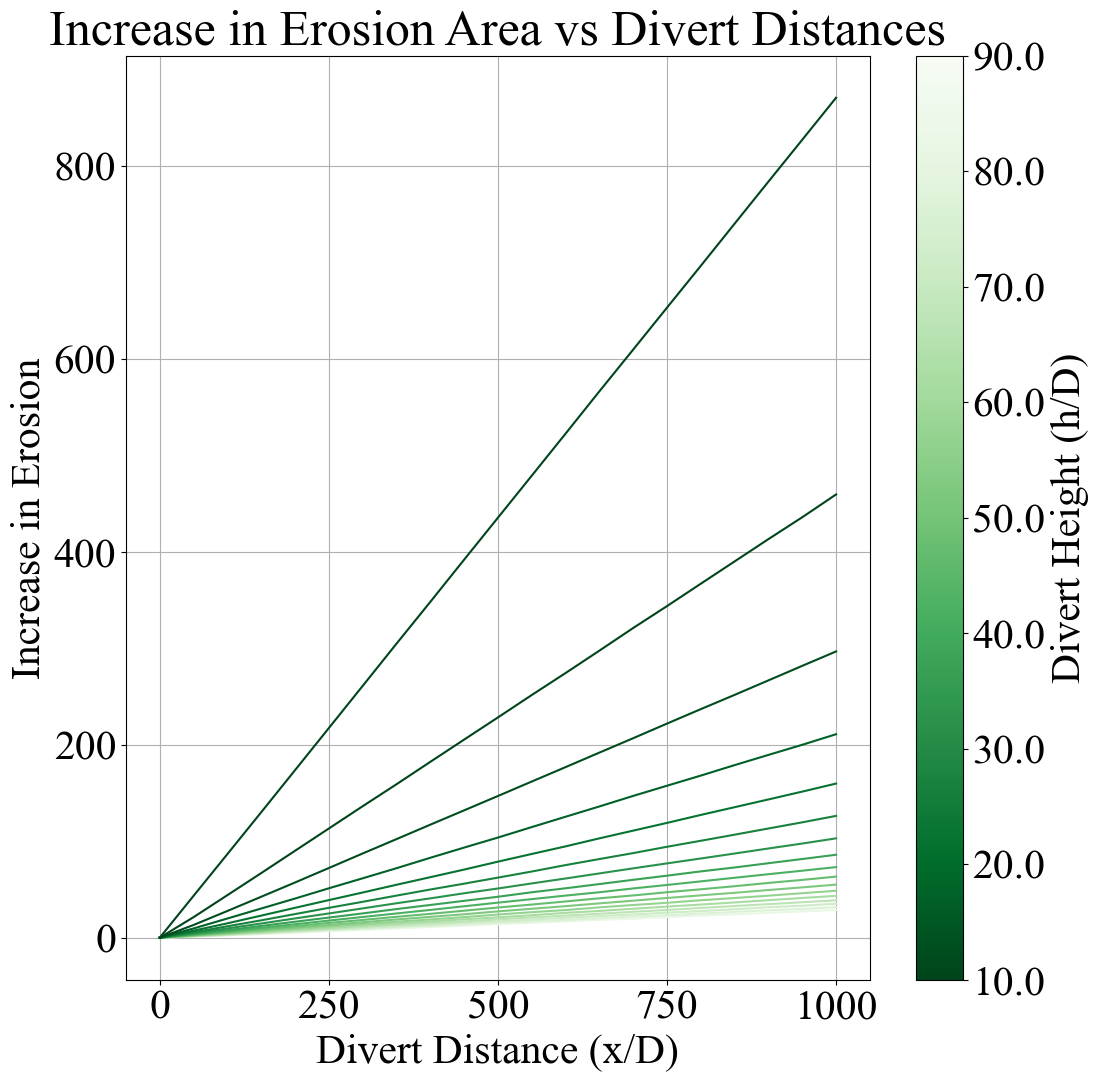

In [93]:
fig, ax = plt.subplots(figsize=(12, 12))
height_num = len(divert_h_arr_hd)

grey_colors = plt.cm.gray(divert_h_arr_hd)

for height_idx in range(height_num):
    height_label = divert_h_arr_hd[height_idx]
    colour = plt.cm.Greens(height_idx / (height_num - 1) + 0.1)
    ax.plot(divert_dist_arr_hd, del_area_results_perc[height_idx, :], label=height_label, color=colour)

# Add colorbar
norm = Normalize(vmin=min(divert_h_arr_hd), vmax=max(divert_h_arr_hd))
sm = ScalarMappable(cmap=plt.cm.Greens_r, norm=norm)
sm.set_array([])

# Specify the Axes for the colorbar
cbar = plt.colorbar(sm, ax=ax, label="Divert Height (h/D)")
cbar.set_ticks(divert_h_arr_hd[::2])
cbar.set_ticklabels(divert_h_arr_hd[::2])

plt.title("Increase in Erosion Area vs Divert Distances")
plt.xlabel("Divert Distance (x/D)")
plt.ylabel("Increase in Erosion")
# ax.legend(title="Divert Height")
plt.grid()
plt.show()

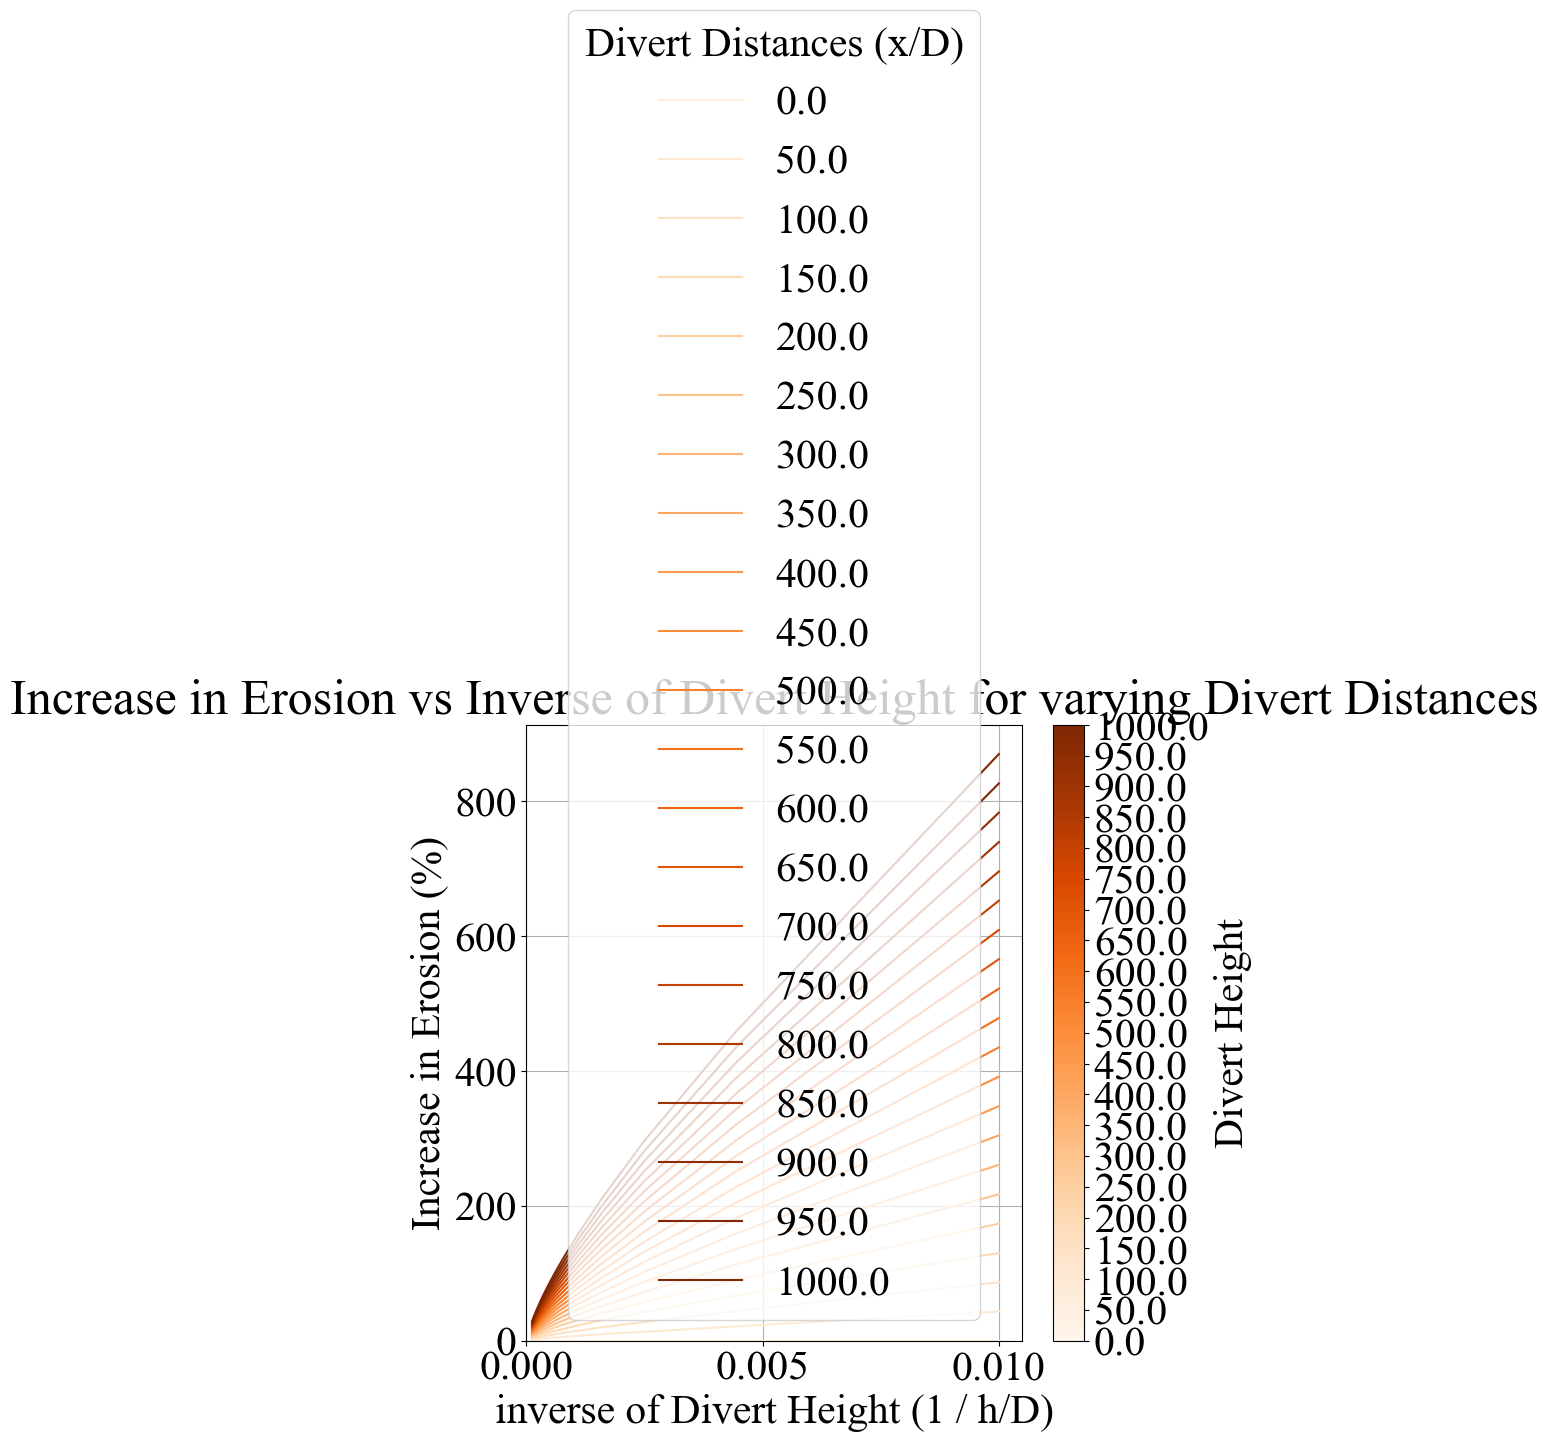

In [94]:
fig, ax = plt.subplots(figsize=(12,12))

grey_colors = plt.cm.gray(divert_dist_arr_hd)

for dist_idx in range(dist_num):
    # colour = grey_colors[dist_idx]
    colour = plt.cm.Oranges(dist_idx / (dist_num - 1) + 0.05)
    ax.plot(1/(pow(divert_h_arr_hd,2)), del_area_results_perc[:,dist_idx], color=colour)


# Add colorbar
norm = Normalize(vmin=min(divert_dist_arr_hd), vmax=max(divert_dist_arr_hd))
sm = ScalarMappable(cmap=plt.cm.Oranges, norm=norm)
sm.set_array([])

# Specify the Axes for the colorbar
cbar = plt.colorbar(sm, ax=ax, label="Divert Height")
cbar.set_ticks(divert_dist_arr_hd)
cbar.set_ticklabels(divert_dist_arr_hd)

plt.title("Increase in Erosion vs Inverse of Divert Height for varying Divert Distances")
plt.xlabel("inverse of Divert Height (1 / h/D)")
plt.ylabel("Increase in Erosion (%)")
plt.ylim(-0.1)
plt.xlim(0)
ax.legend(title="Divert Distances (x/D)")
plt.grid() 
plt.show()